## Do the Estimation with SCE and SPF data


### 1. Importing estimation codes

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.optimize import minimize

import statsmodels.api as sm
from statsmodels.tsa.api import AR

In [2]:
from GMMEst import RationalExpectation as re
from GMMEst import StickyExpectation as se
from GMMEst import NoisyInformation as ni
from GMMEst import ParameterLearning as pl
from GMMEst import AR1_simulator, ForecastPlotDiag, ForecastPlot

In [3]:
## some parameters 
rho = 0.95
sigma = 0.1
process_para = {'rho':rho,
                'sigma':sigma}

### 2. Preparing real-time data 

In [4]:
## CPI Core
InfCPICMRT=pd.read_stata('../OtherData/InfCPICMRealTime.dta')  
InfCPICMRT = InfCPICMRT[-InfCPICMRT.date.isnull()]

## CPI 
InfCPIMRT=pd.read_stata('../OtherData/InfCPIMRealTime.dta')  
InfCPIMRT = InfCPIMRT[-InfCPIMRT.date.isnull()]

In [5]:
## dealing with dates 
dateM_cpic = pd.to_datetime(InfCPICMRT['date'],format='%Y%m%d')
dateM_cpi = pd.to_datetime(InfCPIMRT['date'],format='%Y%m%d')

InfCPICMRT.index = pd.DatetimeIndex(dateM_cpic,freq='infer')
InfCPIMRT.index = pd.DatetimeIndex(dateM_cpi,freq='infer')

In [6]:
## a function that turns vintage matrix to a one-dimension vector of real time data
def GetRealTimeData(matrix):
    periods = len(matrix)
    real_time = np.zeros(periods)
    for i in range(periods):
        real_time[i] = matrix.iloc[i,i+1]
    return real_time

In [7]:
## generate real-time series 
matrix_cpic = InfCPICMRT.copy().drop(columns=['date','year','month'])
matrix_cpi = InfCPIMRT.copy().drop(columns=['date','year','month'])

real_time_cpic = pd.Series(GetRealTimeData(matrix_cpic) )
real_time_cpi =  pd.Series(GetRealTimeData(matrix_cpi) ) 
real_time_cpic.index =  InfCPICMRT.index #+ pd.DateOffset(months=1) 
real_time_cpi.index = InfCPIMRT.index #+ pd.DateOffset(months=1)

In [8]:
## turn index into yearly inflation
real_time_index =pd.concat([real_time_cpic,real_time_cpi], join='inner', axis=1)
real_time_index.columns=['RTCPI','RTCPICore']
real_time_inf = real_time_index.pct_change(periods=12)*100

In [9]:
real_time_inf.tail()

,RTCPI,RTCPICore
date,,
2019-03-01,2.019516,1.878442
2019-04-01,2.060831,1.977897
2019-05-01,2.002032,1.844054
2019-06-01,2.136764,1.773122
2019-07-01,2.186252,1.940021


### 3. Estimating using real-time inflation and expectation data


In [10]:
## exapectation data from SPF 
PopQ=pd.read_stata('../SurveyData/InfExpQ.dta')  
PopQ = PopQ[-PopQ.date.isnull()]
dateQ = pd.to_datetime(PopQ['date'],format='%Y%m%d')
dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)
PopQ.index = pd.DatetimeIndex(dateQ_str)

SPFCPI = PopQ[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']].dropna(how='any')


## expectation data from SCE

PopM = pd.read_stata('../SurveyData/InfExpM.dta')
PopM = PopM[-PopM.date.isnull()]
dateM = pd.to_datetime(PopM['date'],format='%Y%m%d')
dateM_str = dateM.dt.year.astype(int).astype(str) + \
             "M" + dateM.dt.month.astype(int).astype(str)
PopM.index = pd.DatetimeIndex(dateM)
SCECPI = PopM[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']].dropna(how='any')


In [11]:
## Inflation data 

#################
### quarterly ###
#################

InfQ = pd.read_stata('../OtherData/InfShocksQClean.dta')
InfQ = InfQ[-InfQ.date.isnull()]
dateQ2 = pd.to_datetime(InfQ['date'],format='%Y%m%d')
dateQ_str2 = dateQ2 .dt.year.astype(int).astype(str) + \
             "Q" + dateQ2 .dt.quarter.astype(int).astype(str)
InfQ.index = pd.DatetimeIndex(dateQ_str2,freq='infer')

################
## monthly ### 
###############

## inflation data monthly
InfM = pd.read_stata('../OtherData/InfShocksMClean.dta')
InfM = InfM[-InfM.date.isnull()]
dateM = pd.to_datetime(InfM['date'],format='%Y%m%d')
#dateM_str = dateM .dt.year.astype(int).astype(str) + \
#             "M" + dateM .dt.month.astype(int).astype(str)
InfM.index = pd.DatetimeIndex(dateM,freq='infer')

In [12]:
## process parameters estimation 
# period filter 
start_t='1995-01-01'
end_t = '2019-03-30'   # the same period as in Gali (1991)


######################
### quarterly data ##
#####################

CPICQ = InfQ['Inf1y_CPICore'].copy().loc[start_t:end_t]
Y = np.array(CPICQ[1:])
X = np.array(CPICQ[:-1])

ARmodel = AR(CPICQ)
ar_rs = ARmodel.fit(1,trend='nc')
rhoQ_est = ar_rs.params[0]
sigmaQ_est = np.sqrt(sum(ar_rs.resid**2)/(len(CPICQ)-1))

###################
### monthly data ##
####################

CPIM = InfM['Inf1y_CPIAU'].copy().loc[start_t:end_t]
Y = np.array(CPIM[1:])
X = np.array(CPIM[:-1])

ARmodel2 = AR(CPIM)
ar_rs2 = ARmodel2.fit(1,trend='nc')
rhoM_est = ar_rs2.params[0]
sigmaM_est = np.sqrt(sum(ar_rs2.resid**2)/(len(CPIM)-1))

In [13]:
## Combine expectation data and real-time data 

SPF_est = pd.concat([SPFCPI,real_time_inf,InfQ['Inf1y_CPICore'],InfQ['Inf1yf_CPICore']], join='inner', axis=1)
SCE_est = pd.concat([SCECPI,real_time_inf,InfM['Inf1yf_CPIAU']], join='inner', axis=1)

In [14]:
## hisotries data, the series ends at the same dates with real-time data but startes earlier 

st_t_history = '2000-01-01'
ed_t_SPF = SPF_est.index[-1].strftime('%Y%m%d')
ed_t_SCE = SCE_est.index[-1].strftime('%Y-%m-%d')

## get the quarterly index 
indexQ = CPICQ.index

## get history data quarterly and monthly respectively 
historyQ = real_time_inf.loc[indexQ].loc[st_t_history:ed_t_SPF] ## this is monthly. wrong. 
historyM = real_time_inf.loc[st_t_history:ed_t_SCE]

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


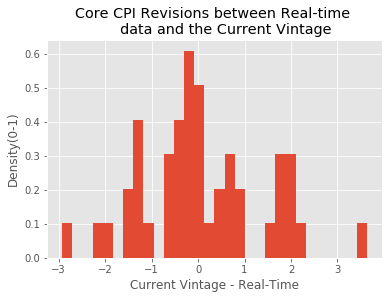

In [15]:
# How large is the difference between current vintage and real-time data
rev = SPF_est['Inf1y_CPICore'] - SPF_est['RTCPICore']

plt.style.use('ggplot')
plt.figure(figsize=([6,4]))
hist_rv = plt.hist(rev,
                   bins=30,
                   density = True)
plt.title('Core CPI Revisions between Real-time \n \
    data and the Current Vintage')
plt.ylabel('Density(0-1)',size=12)
plt.xlabel('Current Vintage - Real-Time',size=12)
plt.savefig('figures/hist_rev_realtime.png')

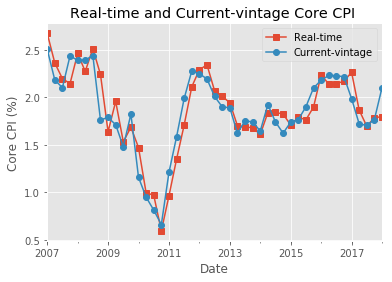

In [16]:
# real time inflation 
real_time = np.array(SPF_est['RTCPI'])

ax = SPF_est[['RTCPI','Inf1y_CPICore']].plot(style=['s-','o-'],
                                             figsize=([6,4]))
#plt.style.use('ggplot')
ax.set_title('Real-time and Current-vintage Core CPI ')
ax.set_xlabel('Date')
ax.set_ylabel('Core CPI (%)')
ax.legend(['Real-time', 'Current-vintage'])
plt.savefig('figures/ts_rev_realtime.png')

In [17]:
## realized 1-year-ahead inflation

realized_CPIC = np.array(SPF_est['Inf1yf_CPICore'])
realized_CPI = np.array(SCE_est['Inf1yf_CPIAU'])

#SPF_est['Inf1yf_CPICore'].plot()
#plt.title('Realized 1-year-ahead Core CPI Inflation')

In [18]:
## preparing data moments  

exp_data_SPF = SPF_est[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']]
exp_data_SPF.columns = ['Forecast','FE','Disg','Var']
data_moms_dct_SPF = dict(exp_data_SPF)

exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']]
exp_data_SCE.columns = ['Forecast','FE','Disg','Var']
data_moms_dct_SCE = dict(exp_data_SCE)

In [19]:
## real time and history 

################
## quarterly ###
#################

real_time_Q = np.array(SPF_est['RTCPI'])
history_Q = historyQ['RTCPICore']

data_moms_dctQ = data_moms_dct_SPF


process_paraQ_est = {'rho':rhoQ_est,
                    'sigma':sigmaQ_est}
##############
## monthly ###
#############

real_time_M = np.array(SCE_est['RTCPI'])
history_M = historyM['RTCPI']
data_moms_dctM = data_moms_dct_SCE


process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

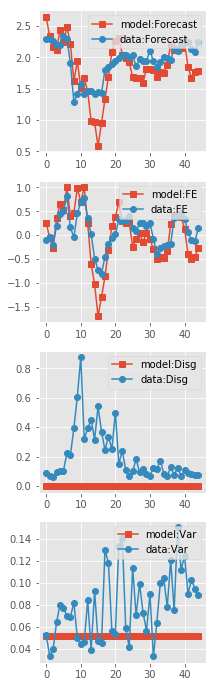

In [20]:
## RE for SPF #
###############

RE_model = re(real_time = real_time_Q,
              history = history_Q,
              process_para = process_paraQ_est)
RE_model.moments = ['Forecast','FE','Disg']
RE_model.GetRealization(realized_CPIC)
RE_model.GetDataMoments(data_moms_dct_SPF)
re_dict = RE_model.Forecaster()

## plot RE forecast moments and data moments 

re_data_plot = ForecastPlotDiag(re_dict,
                                data_moms_dctQ)
plt.savefig('figures/spf_re_est_diag.png')

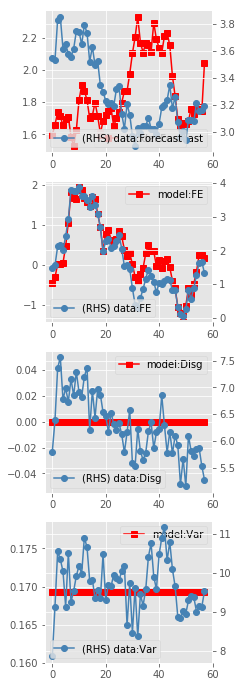

In [21]:
## RE for SCE #
###############

RE_model2 = re(real_time = real_time_M,
               history = history_M,
               process_para = process_paraM_est)
RE_model2.moments = ['Forecast','FE','Disg']
RE_model2.GetRealization(realized_CPI)
RE_model2.GetDataMoments(data_moms_dctM)
re_dict2 = RE_model2.Forecaster()

## plot RE forecast moments and data moments 

re_data_plot2 = ForecastPlotDiag(re_dict2,
                                 data_moms_dctM,
                                 diff_scale = True)
plt.savefig('figures/sce_re_est_diag.png')

moments used include ['Forecast']
moments used include ['FE']
moments used include ['FE', 'Disg']
moments used include ['FE', 'Var']
moments used include ['FE', 'Disg', 'Var']
[array([0.04376902]), array([0.04649047]), array([0.16835353]), array([0.15781878]), array([0.53084084])]


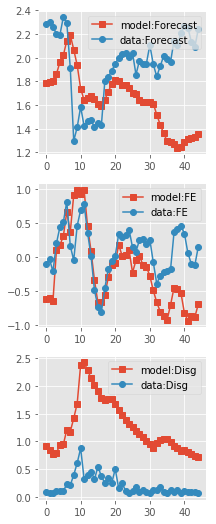

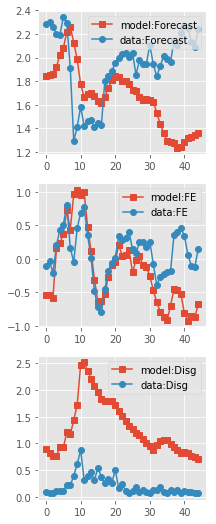

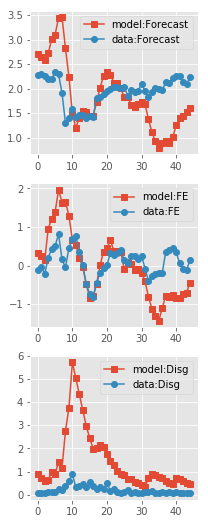

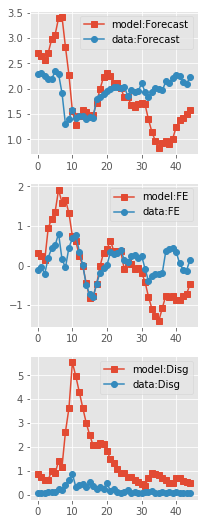

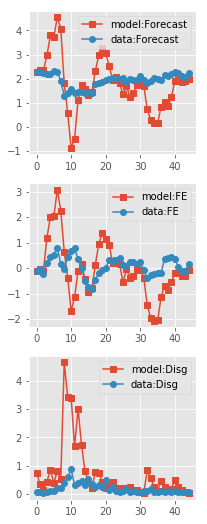

In [52]:
## SE loop estimation overdifferent choieces of moments for SPF

moments_choices_short = [['Forecast']]
moments_choices = [['Forecast'],
                   ['FE'],
                   ['FE','Disg'],
                   ['FE','Var'],
                   ['FE','Disg','Var']]

para_est_SPF_holder = []
para_est_SPF_joint_holder = []

### loop starts from here for SPF 

for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    real_time = np.array(SPF_est['RTCPI'])
    history_Q = historyQ['RTCPICore']
    data_moms_dct = data_moms_dct_SPF
    process_paraQ_est = {'rho':rhoQ_est,
                         'sigma':sigmaQ_est}
    SE_model = se(real_time = real_time,
                  history = history_Q,
                  process_para = process_paraQ_est)
    SE_model.moments = moments_to_use
    SE_model.GetRealization(realized_CPIC)
    SE_model.GetDataMoments(data_moms_dct)
    
    # only expectation
    SE_model.ParaEstimate(method='L-BFGS-B',
                          para_guess = np.array([0.1]),
                          bounds = ((0,1),),
                          options={'disp':True})
    para_est_SPF_holder.append(SE_model.para_est)
    SE_model.all_moments = ['Forecast','FE','Disg']
    SE_model.ForecastPlotDiag(all_moms = True)
    plt.savefig('figures/spf_se_est_diag'+str(i)+'.png')
    
    # joint estimate
    #SE_model.ParaEstimateJoint(method='L-BFGS-B',
    #                           para_guess =(0.5,0.8,0.1),
    #                           bounds = ((0,1),(0,1),(0,None)),
    #                           options={'disp':True})
    #para_est_SPF_joint_holder.append(SE_model.para_est_joint)
    #SE_model.all_moments = ['Forecast','FE','Disg']
    #SE_model.ForecastPlotDiagJoint(all_moms = True)
    #plt.savefig('figures/spf_se_est_joint_diag'+str(i)+'.png')
    
print(para_est_SPF_holder)
#print(para_est_SPF_joint_holder)

In [53]:
## tabulate the estimates 
spf_se_est_para = pd.DataFrame(para_est_SPF_holder,columns=[r'SE: $\hat\lambda_{SPF}$(Q)'])
spf_se_joint_est_para = pd.DataFrame(para_est_SPF_joint_holder,
                                     columns=[r'SE: $\hat\lambda_{SPF}$(Q)',
                                              r'SE: $\rho$',
                                              r'SE: $\sigma$'])

In [54]:
spf_se_est_para

,SE: $\hat\lambda_{SPF}$(Q)
0,0.043769
1,0.046490
2,0.168354
3,0.157819
4,0.530841


In [55]:
#spf_se_joint_est_para

moments used include ['Forecast']
moments used include ['FE']
moments used include ['FE', 'Disg']
moments used include ['FE', 'Var']
moments used include ['FE', 'Disg', 'Var']
[array([1.]), array([0.18748445]), array([0.18698902]), array([0.18246183]), array([0.18196748])]


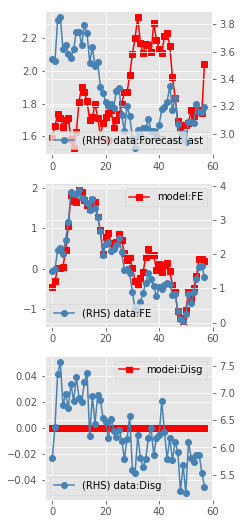

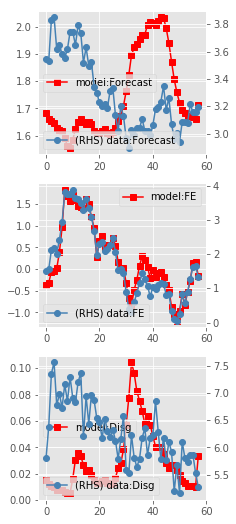

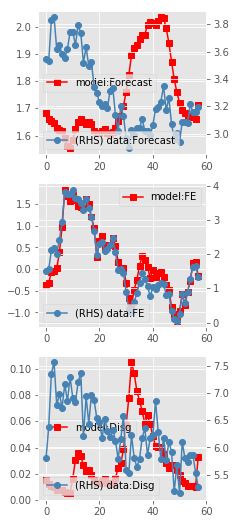

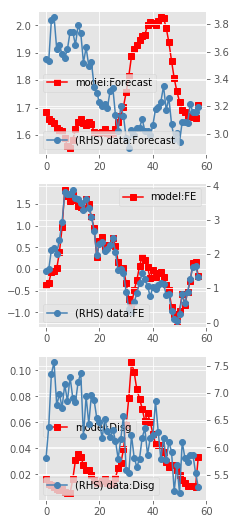

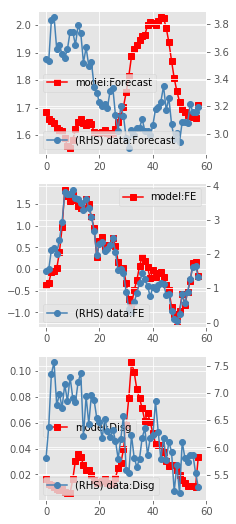

In [56]:
## SE loop estimation over different choieces of moments for SCE

moments_choices_short =[['Forecast']]
moments_choices = [['Forecast'],
                   ['FE'],
                   ['FE','Disg'],
                   ['FE','Var'],
                   ['FE','Disg','Var']]

para_est_SCE_holder = []
para_est_SCE_joint_holder =[]


for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    real_time = np.array(SCE_est['RTCPI'])
    history_M = historyM['RTCPI']
    data_moms_dct = data_moms_dct_SCE
    process_paraM_est = {'rho':rhoM_est,
                         'sigma':sigmaM_est}
    SE_model2 = se(real_time = realized_CPI,
                   history = history_M,
                   process_para = process_paraM_est)
    SE_model2.moments = moments_to_use
    SE_model2.GetRealization(realized_CPI)
    SE_model2.GetDataMoments(data_moms_dct)
    
    ## only expectation
    SE_model2.ParaEstimate(method='L-BFGS-B',
                           para_guess =(0.5),
                           bounds = ((0,1),),
                           options={'disp':True})
    para_est_SCE_holder.append(SE_model2.para_est)
    SE_model2.all_moments = ['Forecast','FE','Disg']
    SE_model2.ForecastPlotDiag(all_moms = True,
                               diff_scale = True)
    plt.savefig('figures/sce_se_est_diag'+str(i)+'.png')
    
    ## joint estimation
    
    #SE_model2.ParaEstimateJoint(method='L-BFGS-B',
    #                            para_guess =(0.5,0.8,0.1),
    #                            bounds = ((0,1),(0,1),(0,None)),
    #                            options={'disp':True})
    #para_est_SCE_joint_holder.append(SE_model2.para_est_joint)
    #SE_model2.all_moments = ['Forecast','FE','Disg']
    #SE_model2.ForecastPlotDiag(all_moms = True,
    #                           diff_scale = True)
    #plt.savefig('figures/sce_se_est_joint_diag'+str(i)+'.png')

print(para_est_SCE_holder)
#print(para_est_SCE_joint_holder)

In [57]:
sce_se_est_para = pd.DataFrame(para_est_SCE_holder,
                               columns=[r'SE: $\hat\lambda_{SCE}$(M)'])
#sce_se_joint_est_para = pd.DataFrame(para_est_SCE_joint_holder,
#                                     columns = [r'SE: $\hat\lambda_{SCE}$(M)',
#                                                r'SE: $\rho$',
#                                                r'SE: $\sigma$'])



In [62]:
est_moms = pd.DataFrame(moments_choices)

## combining SCE and SPF 
se_est_df = pd.concat([est_moms,
                       spf_se_est_para,
                       sce_se_est_para], 
                      join='inner', axis=1)

In [63]:
sce_se_est_para

,SE: $\hat\lambda_{SCE}$(M)
0,1.000000
1,0.187484
2,0.186989
3,0.182462
4,0.181967


In [64]:
#sce_se_joint_est_para

In [65]:
se_est_df.to_excel('tables/SE_Est.xlsx',
                   float_format='%.2f',
                   index = False)

moments used include ['Forecast']
moments used include ['FE']
moments used include ['FE', 'Disg']
moments used include ['FE', 'Var']
moments used include ['FE', 'Disg', 'Var']
[array([ 66.04329401, 297.9446326 ,  72.8602153 ]), array([1.43848681, 0.16122731, 0.09999976]), array([1.48450797, 0.16185888, 0.09999972]), array([72.321509  ,  0.16109539,  0.0999998 ]), array([81.19927251,  0.16171119,  0.09999976])]


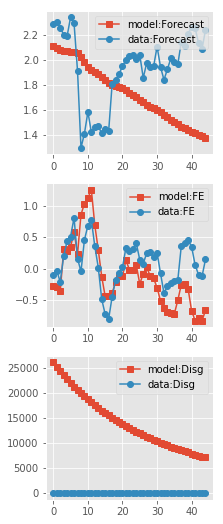

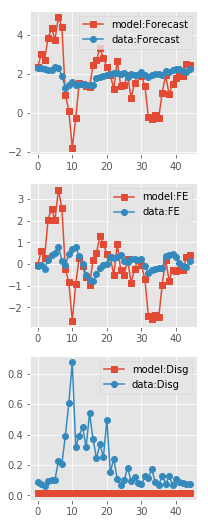

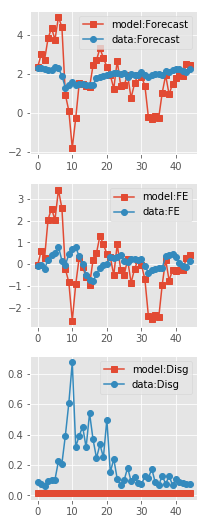

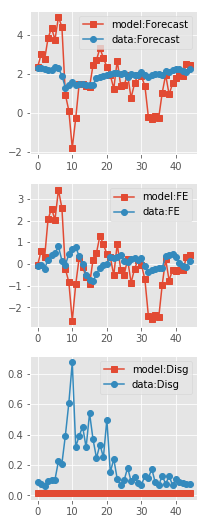

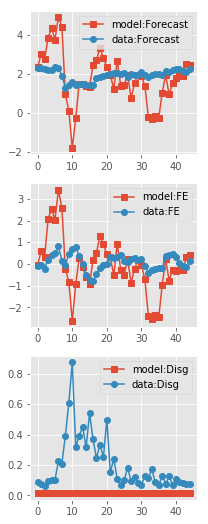

In [22]:
## NI loop estimation overdifferent choieces of moments for SPF

moments_choices_short = [['Forecast']]
moments_choices = [['Forecast'],
                   ['FE'],
                   ['FE','Disg'],
                   ['FE','Var'],
                   ['FE','Disg','Var']]

para_est_SPF_holder = []
para_est_SPF_joint_holder = []

### loop starts from here for SPF 

for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    real_time = np.array(SPF_est['RTCPI'])
    history_Q = historyQ['RTCPICore']
    data_moms_dct = data_moms_dct_SPF
    process_paraQ_est = {'rho':rhoQ_est,
                         'sigma':sigmaQ_est}
    NI_model = ni(real_time = real_time,
                  history = history_Q,
                  process_para = process_paraQ_est)
    NI_model.SimulateSignals()
    NI_model.moments = moments_to_use
    NI_model.GetRealization(realized_CPIC)
    NI_model.GetDataMoments(data_moms_dct)
    
    # only expectation
    NI_model.ParaEstimate(method='L-BFGS-B',
                          para_guess = (0.5,0.5,0.1),
                          bounds = ((0,None),(0,None),(0,None)),
                          options={'disp':True})
    para_est_SPF_holder.append(NI_model.para_est)
    NI_model.all_moments = ['Forecast','FE','Disg']
    NI_model.ForecastPlotDiag(all_moms = True)
    plt.savefig('figures/spf_ni_est_diag'+str(i)+'.png')
    
    # joint estimate
    #NI_model.ParaEstimateJoint(method='L-BFGS-B',
    #                           para_guess =(0.5,0.5,0.1,1,0.1),
    #                           bounds = ((0,None),(0,None),(0,None),(0,1),(0,None)),
    #                           options={'disp':True})
    #para_est_SPF_joint_holder.append(NI_model.para_est_joint)
    #NI_model.all_moments = ['Forecast','FE','Disg']
    #NI_model.ForecastPlotDiagJoint(all_moms = True)
    #plt.savefig('figures/spf_ni_est_joint_diag'+str(i)+'.png')
    
print(para_est_SPF_holder)
#print(para_est_SPF_joint_holder)

In [23]:
## tabulate the estimates 
spf_ni_est_para = pd.DataFrame(para_est_SPF_holder,
                               columns=[r'NI: $\hat\sigma_{pb,SPF}$',
                                        r'$\hat\sigma_{pr,SPF}$',
                                        r'$Var$'])
#spf_ni_joint_est_para = pd.DataFrame(para_est_SPF_joint_holder,
#                                     columns=[r'NI: $\hat\sigma_{pb,SPF}$',
#                                              r'$\hat\sigma_{pr,SPF}$',
#                                              r'$Var$',
#                                              r'NI: $\rho$',
#                                              r'NI: $\sigma$'])

In [24]:
spf_ni_est_para

,"NI: $\hat\sigma_{pb,SPF}$","$\hat\sigma_{pr,SPF}$",$Var$
0,66.043294,297.944633,72.860215
1,1.438487,0.161227,0.100000
2,1.484508,0.161859,0.100000
3,72.321509,0.161095,0.100000
4,81.199273,0.161711,0.100000


In [25]:
#spf_ni_joint_est_para

moments used include ['Forecast']
moments used include ['FE']
moments used include ['FE', 'Disg']
moments used include ['FE', 'Var']
moments used include ['FE', 'Disg', 'Var']
[array([ 66.04329401, 297.9446326 ,  72.8602153 ]), array([1.43848681, 0.16122731, 0.09999976]), array([1.48450797, 0.16185888, 0.09999972]), array([72.321509  ,  0.16109539,  0.0999998 ]), array([81.19927251,  0.16171119,  0.09999976])]


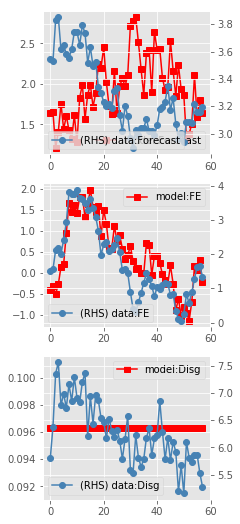

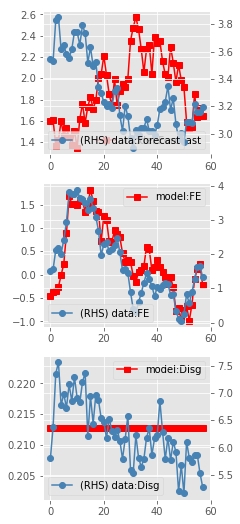

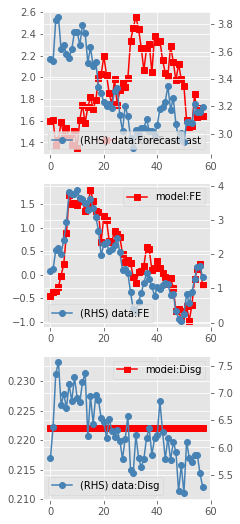

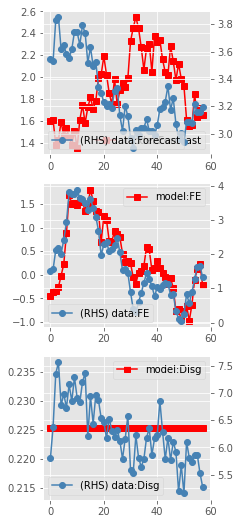

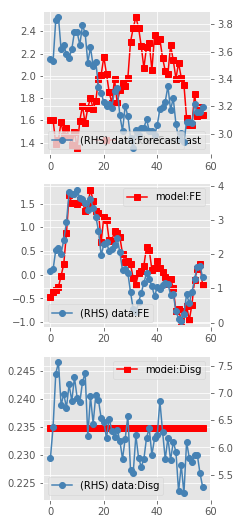

In [26]:
## NI loop estimation overdifferent choieces of moments for SCE

moments_choices_short = [['Forecast']]
moments_choices = [['Forecast'],
                   ['FE'],
                   ['FE','Disg'],
                   ['FE','Var'],
                   ['FE','Disg','Var']]

para_est_SCE_holder = []
para_est_SCE_joint_holder = []

### loop starts from here for SPF 

for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    real_time = np.array(SCE_est['RTCPI'])
    history_M = historyM['RTCPI']
    data_moms_dct = data_moms_dct_SCE
    process_paraM_est = {'rho':rhoM_est,
                         'sigma':sigmaM_est}
    NI_model2 = ni(real_time = real_time,
                   history = history_M,
                   process_para = process_paraM_est)
    NI_model2.SimulateSignals()
    NI_model2.moments = moments_to_use
    NI_model2.GetRealization(realized_CPI)
    NI_model2.GetDataMoments(data_moms_dct)
    
    # only expectation
    NI_model2.ParaEstimate(method='L-BFGS-B',
                           para_guess =(0.5,0.5,0.5),
                           bounds =((0,None),(0,None),(0,None)),
                           options={'disp':True})
    para_est_SCE_holder.append(NI_model2.para_est)
    NI_model2.all_moments = ['Forecast','FE','Disg']
    NI_model2.ForecastPlotDiag(all_moms = True,
                               diff_scale= True)
    plt.savefig('figures/sce_ni_est_diag'+str(i)+'.png')
    
    # joint estimate
    #NI_model2.ParaEstimateJoint(method='L-BFGS-B',
    #                           para_guess =(0.5,0.5,0.1,0.8,0.1),
    #                           bounds = ((0,None),(0,None),(0,None),(0,1),(0,None)),
    #                           options={'disp':True})
    #para_est_SCE_joint_holder.append(NI_model2.para_est_joint)
    #NI_model.all_moments = ['Forecast','FE','Disg']
    #NI_model2.ForecastPlotDiagJoint(all_moms = True,
    #                                diff_scale = True)
    #plt.savefig('figures/sce_ni_est_joint_diag'+str(i)+'.png')
    
print(para_est_SPF_holder)
#print(para_est_SPF_joint_holder)

In [27]:
## tabulate the estimates 
sce_ni_est_para = pd.DataFrame(para_est_SCE_holder,
                               columns=[r'NI: $\hat\sigma_{pb,SCE}$',
                                        r'$\hat\sigma_{pr,SCE}$',
                                        r'$Var$'])
#sce_ni_joint_est_para = pd.DataFrame(para_est_SCE_joint_holder,
#                                     columns=[r'NI: $\hat\sigma_{pb,SCE}$',
#                                              r'$\hat\sigma_{pr,SCE}$',
#                                              r'$Var$',
#                                              r'NI: $\rho$',
#                                              r'NI: $\sigma$'])


In [28]:
sce_ni_est_para

,"NI: $\hat\sigma_{pb,SCE}$","$\hat\sigma_{pr,SCE}$",$Var$
0,31.857262,0.528300,0.5
1,106.354469,1.153914,0.5
2,153.583015,1.207284,0.5
3,160.155073,1.226424,0.5
4,137.646025,1.281608,0.5


In [29]:
#sce_ni_joint_est_para

In [30]:
est_moms = pd.DataFrame(moments_choices)

## combining SCE and SPF 
ni_est_df = pd.concat([est_moms,
                       spf_ni_est_para,
                       sce_ni_est_para],
                      join='inner', axis=1)

In [31]:
ni_est_df

,0,1,2,"NI: $\hat\sigma_{pb,SPF}$","$\hat\sigma_{pr,SPF}$",$Var$,"NI: $\hat\sigma_{pb,SCE}$","$\hat\sigma_{pr,SCE}$",$Var$
0,Forecast,None,None,66.043294,297.944633,72.860215,31.857262,0.528300,0.5
1,FE,None,None,1.438487,0.161227,0.100000,106.354469,1.153914,0.5
2,FE,Disg,None,1.484508,0.161859,0.100000,153.583015,1.207284,0.5
3,FE,Var,None,72.321509,0.161095,0.100000,160.155073,1.226424,0.5
4,FE,Disg,Var,81.199273,0.161711,0.100000,137.646025,1.281608,0.5


In [32]:
ni_est_df.to_excel('tables/NI_Est.xlsx',
                   float_format='%.2f',
                   index=False)

In [46]:
### Estimate of Parameter Learning for SPF

real_time = np.array(SPF_est['RTCPI'])
data_moms_dct = data_moms_dct_SPF

process_paraQ_est = {'rho':rhoQ_est,
                    'sigma':sigmaQ_est}

PL_model = pl(real_time = real_time,
              history = history_Q,
              process_para = process_paraQ_est,
              moments = ['Forecast','FE','Disg','Var'])

PL_model.GetRealization(realized_CPIC)
PL_model.LearnParameters()
moms_pl_sim = PL_model.Forecaster()
PL_model.GetDataMoments(data_moms_dct)

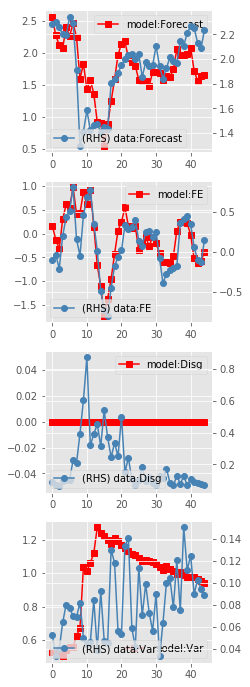

In [47]:
pl_plot = ForecastPlotDiag(moms_pl_sim,
                           data_moms_dct,
                           legends = ['model','data'],
                           diff_scale = True)

plt.savefig('figures/spf_pl_est_diag.png')

In [48]:
### Estimate of Parameter Learning for SCE

real_time = np.array(SCE_est['RTCPI'])
data_moms_dct2 = data_moms_dct_SCE

process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

PL_model2 = pl(real_time = real_time,
              history = history_M,
              process_para = process_paraM_est,
              moments = ['Forecast','FE','Disg','Var'])

PL_model2.GetRealization(realized_CPI)
PL_model2.LearnParameters()
moms_pl_sim2 = PL_model2.Forecaster()
PL_model2.GetDataMoments(data_moms_dct2)

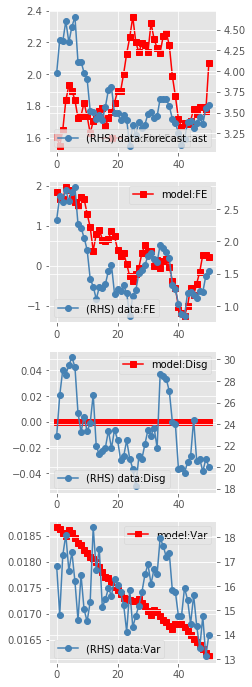

In [49]:
pl_plot = ForecastPlotDiag(moms_pl_sim2,
                           data_moms_dct2,
                           legends=['model','data'],
                           diff_scale = True)

plt.savefig('figures/sce_pl_est_diag.png')